In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from functools import reduce
import scipy
from copy import deepcopy
from scipy.linalg import logm
import numpy as np
import dill


In [3]:
import dill 
num_keep = 200
filename = 'pickled_controls5.pkl'
pca = dill.load(open(filename, 'rb'))
pca.controlset = pca.controlset[:num_keep]

In [4]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx

# Plotting Utils

In [5]:
%matplotlib inline 
def oned_off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = list(zip(values, [0 for _ in values]))
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()
    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    
    for i, row in enumerate(projs[:-1, :]):
        plt.plot(range(len(row)), row)
    plt.plot(range(len(projs[-1, :])), projs[-1, :], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.axvline((num_points-1)/2)
    plt.subplot(212)  # the second subplot in the first figure
    
    for i, row in enumerate(fidelities[:-1, :]):
        plt.plot(range(len(row)), -np.log(1 - row))
    plt.plot(range(len(fidelities[-1, :])), -np.log(1 - fidelities[-1, :]), label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()

def off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt

    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure

    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), -np.log(1 - reordered_row))
    plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()
    
def off_diagonals2(pca1, pca2, scale):
    for l, pca in enumerate([pca1, pca2]):
        import itertools
        from itertools import product
        import multiprocessing
        from pauli_channel_approximation import compute_dpn_and_fid
        import matplotlib.pyplot as plt
        
        def generate_indices(num_points, order_desired):
            num_indices = len(order_desired)
            tuples = product(range(num_points), repeat=num_indices)
            indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
            return indices

        values_to_plot = []
        corr = []
        for i, detuning in enumerate(pca.detunings):
            # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
            values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
            values_to_plot.append(values)
            corr.append(i)
        # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
        combinations = itertools.product(*values_to_plot)
        new_combinations = []
        for combo in combinations:
            new_combo = []
            for index in corr:
                new_combo.append(combo[index])
            new_combinations.append(new_combo)
        combinations = new_combinations

        tuple_length = len(combinations[0])
        standard_ordering = list(range(tuple_length))
        ordering = standard_ordering
        indices = generate_indices(len(values), ordering)

        # Multiprocessing for faster evaluation.
        pool = multiprocessing.Pool(num_processors)
        lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs)
               for combo in combinations]
        projs_fidelities = pool.map(compute_dpn_and_fid, lst)
        pool.close()

        # Compute the off diagonals and fidelities.
        projs = [pf[0] for pf in projs_fidelities]
        fidelities = [pf[1] for pf in projs_fidelities]
        projs = np.vstack(projs).T
        fidelities = np.vstack(fidelities).T
        # If you just uncomment the first two rows it fails for some reason...
#         for i, row in enumerate(projs[:-1, :]):
#             reordered_row = np.array([row[j] for j in indices])
#             plt.plot(range(len(row)), reordered_row)
        plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], c=['r','b'][l], linewidth=2, zorder=10, label=['1st order', '0th order'][l])
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()


In [6]:
num_weights = 8
scale = 100
num_points = 11
num_processors = 4

In [7]:
from convex import all_derivs, optimal_weights_1st_order, optimal_weights
from pauli_channel_approximation import PCA
# If the tolerance is too high (i.e. not zero) and the number of controls is too high (e.g. >100) this was failing with ECOS.
PCA.assign_weights(pca, 0, 1E-3)

SUPPORT:1.0000004380902505
NUM CONTROLS: 8


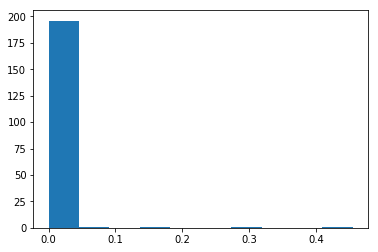

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
indices = hist_and_support(pca.weights, num_weights)

In [9]:
indices

array([142, 104, 169, 128, 160,  61, 168, 112])

DOING COMBO [-1e-05, 6.000000000000002e-06]
DOING COMBO [-1e-05, -1e-05]
DOING COMBO [-8.000000000000001e-06, 1.6940658945086007e-21]
DOING COMBO [-6e-06, -6e-06]
DOING COMBO [-6e-06, -4e-06]
DOING COMBO [-1e-05, 8.000000000000003e-06]
DOING COMBO [-1e-05, -8.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, 2.000000000000001e-06]
DOING COMBO [-6e-06, -1.9999999999999995e-06]
DOING COMBO [-1e-05, 1e-05]
DOING COMBO [-8.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [-1e-05, -6e-06]
DOING COMBO [-6e-06, 1.6940658945086007e-21]
DOING COMBO [-8.000000000000001e-06, -1e-05]
DOING COMBO [-8.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [-1e-05, -4e-06]
DOING COMBO [-6e-06, 2.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, -8.000000000000001e-06]
DOING COMBO [-1e-05, -1.9999999999999995e-06]
DOING COMBO [-8.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [-8.000000000000001e-06, -6e-06]
DOING COMBO [-6e-06, 4.000000000000001e-06]
DOING COMBO [-1e-

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


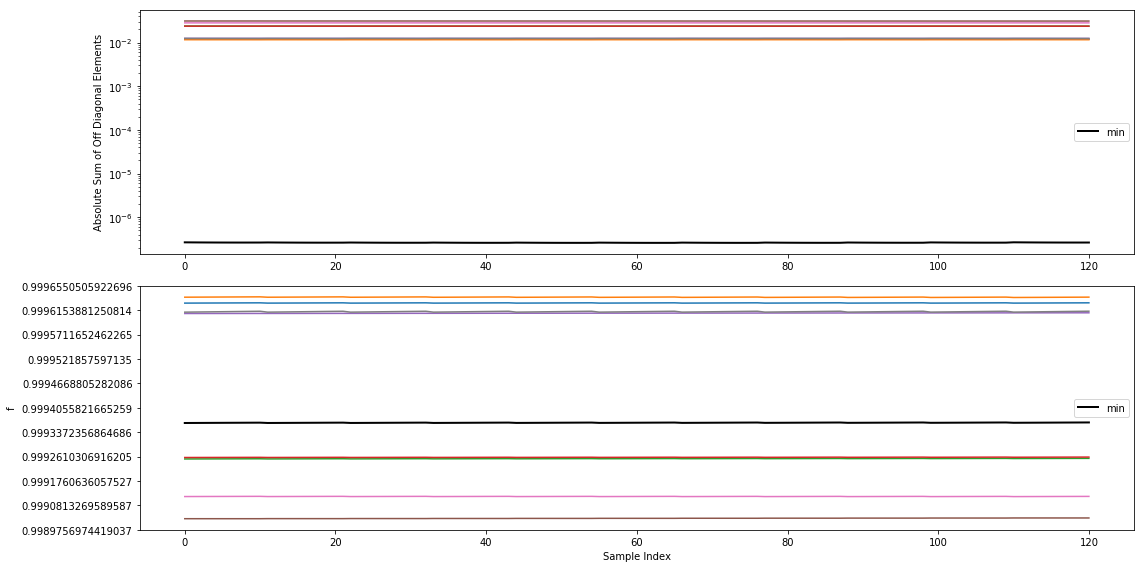

In [10]:
#pca1 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca1 = dill.load(open(filename, 'rb'))
subweights = pca.weights[indices]
pca1.controlset = [pca1.controlset[i] for i in indices]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca1, scale)


SUPPORT:0.9999995614652653
NUM CONTROLS: 8


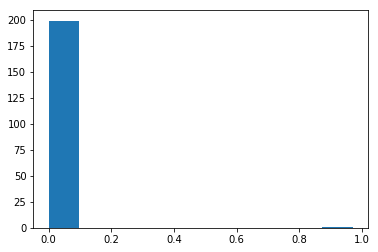

In [11]:
import matplotlib.pyplot as plt
num_weights0 = num_weights
%matplotlib inline
indices = hist_and_support(pca.weights_0, num_weights0)

SUPPORT:0.9999995614652653
NUM CONTROLS: 8
DOING COMBO [-8.000000000000001e-06, 1.6940658945086007e-21]
DOING COMBO [-6e-06, -6e-06]
DOING COMBO [-1e-05, 6.000000000000002e-06]
DOING COMBO [-1e-05, -1e-05]
DOING COMBO [-8.000000000000001e-06, 2.000000000000001e-06]
DOING COMBO [-1e-05, 8.000000000000003e-06]
DOING COMBO [-1e-05, -8.000000000000001e-06]
DOING COMBO [-6e-06, -4e-06]
DOING COMBO [-8.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [-1e-05, 1e-05]
DOING COMBO [-1e-05, -6e-06]
DOING COMBO [-6e-06, -1.9999999999999995e-06]
DOING COMBO [-8.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [-8.000000000000001e-06, -1e-05]
DOING COMBO [-1e-05, -4e-06]
DOING COMBO [-6e-06, 1.6940658945086007e-21]
DOING COMBO [-8.000000000000001e-06, -8.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [-1e-05, -1.9999999999999995e-06]
DOING COMBO [-6e-06, 2.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, -6e-06]
DOING COMBO [-1e-0

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


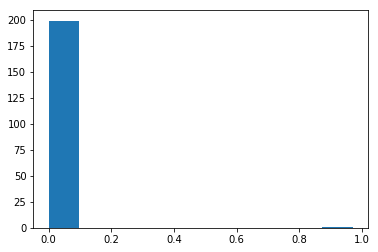

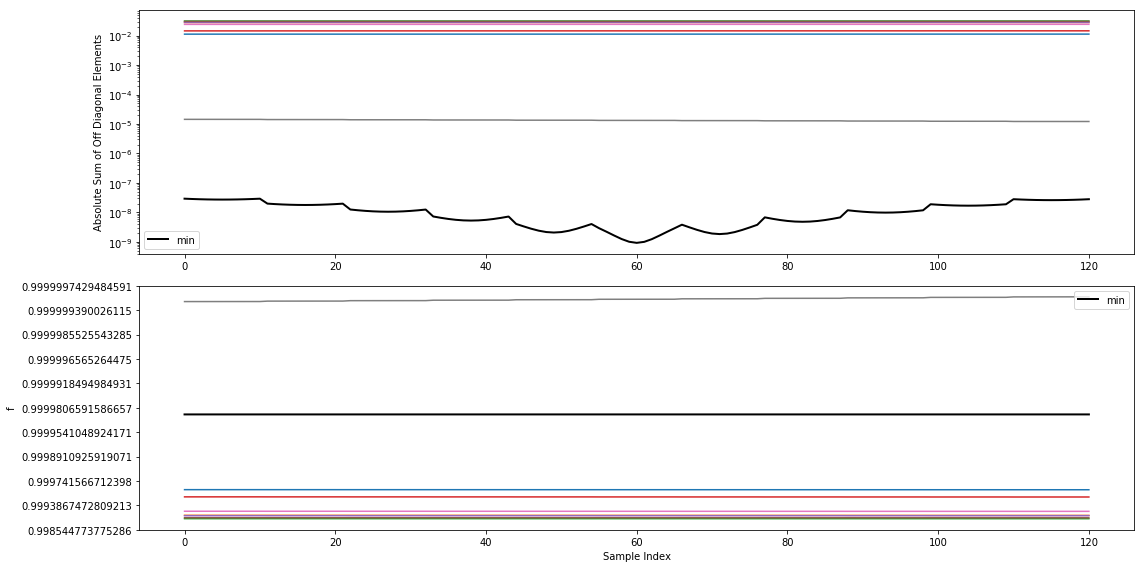

In [12]:
import matplotlib.pyplot as plt

#pca0 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca0 = dill.load(open(filename, 'rb'))
indices = hist_and_support(pca.weights_0, num_weights0)
subweights = pca.weights_0[indices]
pca0.controlset = [pca0.controlset[i] for i in indices]
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca0, scale)


DOING COMBO [-8e-05, -8e-05]
DOING COMBO [-6.400000000000001e-05, 1.3552527156068805e-20]
DOING COMBO [-4.8e-05, -4.8e-05]
DOING COMBO [-8e-05, 4.8000000000000015e-05]
DOING COMBO [-6.400000000000001e-05, 1.600000000000001e-05]
DOING COMBO [-8e-05, -6.400000000000001e-05]
DOING COMBO [-8e-05, 6.400000000000002e-05]
DOING COMBO [-4.8e-05, -3.2e-05]
DOING COMBO [-6.400000000000001e-05, 3.2000000000000005e-05]
DOING COMBO [-8e-05, 8e-05]
DOING COMBO [-8e-05, -4.8e-05]
DOING COMBO [-4.8e-05, -1.5999999999999996e-05]
DOING COMBO [-6.400000000000001e-05, -8e-05]
DOING COMBO [-4.8e-05, 1.3552527156068805e-20]
DOING COMBO [-6.400000000000001e-05, 4.8000000000000015e-05]
DOING COMBO [-8e-05, -3.2e-05]
DOING COMBO [-4.8e-05, 1.600000000000001e-05]
DOING COMBO [-6.400000000000001e-05, -6.400000000000001e-05]
DOING COMBO [-4.8e-05, 3.2000000000000005e-05]
DOING COMBO [-8e-05, -1.5999999999999996e-05]
DOING COMBO [-6.400000000000001e-05, 6.400000000000002e-05]
DOING COMBO [-4.8e-05, 4.8000000000000

DOING COMBO [-1.5999999999999996e-05, -8e-05]
DOING COMBO [-3.2e-05, -1.5999999999999996e-05]
DOING COMBO [1.3552527156068805e-20, -1.5999999999999996e-05]
DOING COMBO [-1.5999999999999996e-05, -6.400000000000001e-05]
DOING COMBO [-3.2e-05, 1.3552527156068805e-20]
DOING COMBO [-1.5999999999999996e-05, 4.8000000000000015e-05]
DOING COMBO [1.3552527156068805e-20, 1.3552527156068805e-20]
DOING COMBO [-1.5999999999999996e-05, -4.8e-05]
DOING COMBO [-3.2e-05, 1.600000000000001e-05]
DOING COMBO [-1.5999999999999996e-05, 6.400000000000002e-05]
DOING COMBO [-1.5999999999999996e-05, -3.2e-05]
DOING COMBO [1.3552527156068805e-20, 1.600000000000001e-05]
DOING COMBO [1.3552527156068805e-20, 6.400000000000002e-05]
DOING COMBO [1.600000000000001e-05, 1.600000000000001e-05]
DOING COMBO [-1.5999999999999996e-05, 8e-05]
DOING COMBO [1.3552527156068805e-20, 8e-05]
DOING COMBO [1.3552527156068805e-20, 3.2000000000000005e-05]
DOING COMBO [1.600000000000001e-05, 3.2000000000000005e-05]
DOING COMBO [1.35525

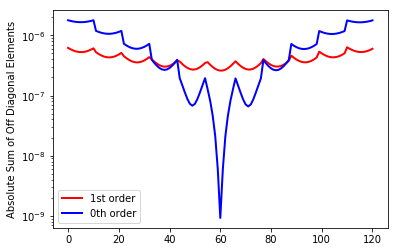

In [13]:
off_diagonals2(pca1, pca0, scale/8)

# Diamond Norm

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('white')

In [37]:
from ipyparallel import Client
rc = Client()
dc = rc[:]

In [38]:
import os
dc.push({'cwd':os.getcwd()})

<AsyncResult: _push>

In [16]:
import dill
import itertools
import numpy as np
from pauli_channel_approximation import compute_dpn_and_fid
import matplotlib.pyplot as plt
from itertools import product

In [17]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [18]:
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
import sys
import itertools
from itertools import product
from copy import deepcopy
from functools import reduce

from diamond import diamond_norm, jamiolkowski

def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)

def choi_form(unitary):

    return jamiolkowski(superoperator(unitary))

def diamond_distance(unitary_a,unitary_b):
    return diamond_norm(choi_form(unitary_a) - choi_form(unitary_b))/2.

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
#     print("DOING COMBO {}".format(combo))
#     sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []
    #
    #
    # for i, com in enumerate(combo):
    #     if i != 0 and com != 0:
    #         return 0
    for cind, controls in enumerate(controlset):
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        ddist = diamond_distance(sop, np.eye(sop.shape[0]))
        with open('./data/{}.out'.format(rank), 'a+') as f:
            f.write("{}\t{}\t{}\n".format(cind,combo,ddist))
        d_norms.append(ddist)
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    ddist = diamond_distance(avg_sop, np.eye(avg_sop.shape[0]))
    with open('./data/{}.out'.format(rank), 'a+') as f:
            f.write("{}\t{}\t{}\n".format("avg",combo,ddist))
    d_norms.append(ddist)

    return d_norms

def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] 
                    for i in range(num_indices)]) for t in tuples]
    return indices

In [19]:
sigI = np.array([[1.,0],[0, 1]], dtype='complex')
sigX = np.array([[0, 1],[1, 0]], dtype='complex')
sigY = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
sigZ = np.array([[1, 0],[0,-1]], dtype='complex')
sigM = (sigX - 1.j*sigY)/2.
sigP = (sigX + 1.j*sigY)/2.
diamond_distance(sigX,sigY)

0.9999999953656783

In [20]:
pca = pca1

In [43]:
num_pts = 10
base = np.logspace(-4.7, np.log(pca.detunings[0][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations0 = [[det,0] for det in controls]

base = np.logspace(-4.7, np.log(pca.detunings[1][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations1 = [[0,det] for det in controls]

d_norms0 = []
for i in range(len(combinations0)):
    combo = combinations0[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms0.append(compute_diamond_norm(lst))

d_norms1 = []
for i in range(len(combinations1)):
    combo = combinations1[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms1.append(compute_diamond_norm(lst))


In [47]:
# diamond_norms = np.array([rc[i]['d_norms'] for i in range(20)])
# controls = np.array([rc[i]['combo'][0] for i in range(20)])
#diamond_norms = np.array(d_norms0)
controls = np.array(controls)

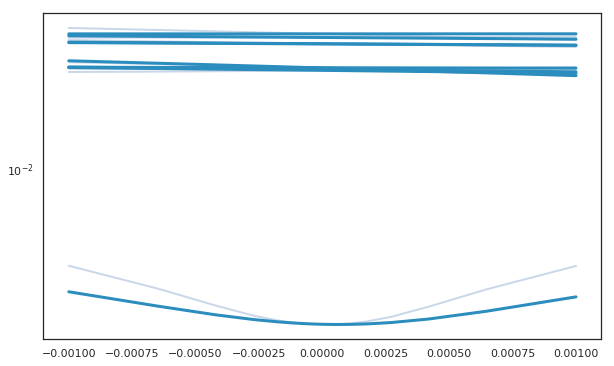

In [49]:
plt.figure(figsize=(10,6))
plt.semilogy(controls, d_norms0, linewidth = 2, alpha=.6, color='#a6bddb');
plt.semilogy(controls,d_norms1, linewidth = 3, alpha=1, color='#2b8cbe');

In [54]:
np.save('dnorms0', d_norms0)

In [55]:
np.save('dnorms1', d_norms1)

In [56]:
from time import time
start = time()
num_pts = 10
base = np.logspace(-4.7, np.log(pca.detunings[0][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations0 = [[det,0] for det in controls]

base = np.logspace(-4.7, np.log(pca.detunings[1][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations1 = [[0,det] for det in controls]

d_norms2 = []
for i in range(len(combinations0)):
    combo = combinations0[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms2.append(compute_diamond_norm(lst))

d_norms3 = []
for i in range(len(combinations1)):
    combo = combinations1[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms3.append(compute_diamond_norm(lst))
stop = time()
print(stop - start)

1072.8359298706055


In [57]:
# diamond_norms = np.array([rc[i]['d_norms'] for i in range(20)])
# controls = np.array([rc[i]['combo'][0] for i in range(20)])
#diamond_norms = np.array(d_norms0)
controls = np.array(controls)

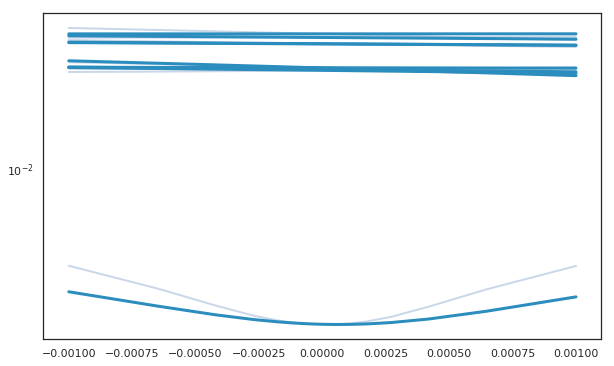

In [58]:
plt.figure(figsize=(10,6))
plt.semilogy(controls, d_norms0, linewidth = 2, alpha=.6, color='#a6bddb');
plt.semilogy(controls,d_norms1, linewidth = 3, alpha=1, color='#2b8cbe');

In [59]:
np.save('dnorms2', d_norms2)

In [60]:
np.save('dnorms3', d_norms3)

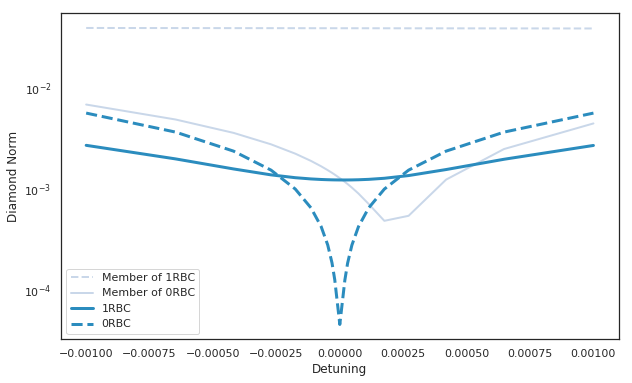

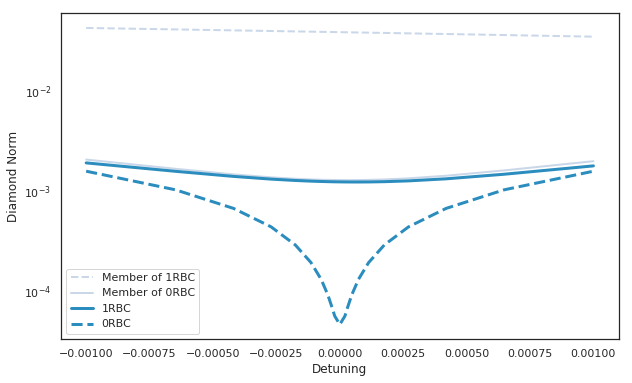

In [118]:
for a, b in ((d_norms0, d_norms2), (d_norms1, d_norms3)):
    plt.figure(figsize=(10,6))
    plt.semilogy(controls, np.array(a).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 1RBC", ls="--");
    plt.semilogy(controls, np.array(b).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 0RBC", ls="-");


    plt.semilogy(controls, np.array(a).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="1RBC", ls="-");
    plt.semilogy(controls,np.array(b).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="0RBC", ls="--");
    plt.ylabel("Diamond Norm")
    plt.xlabel("Detuning")
    plt.legend()

array([[0.03898629, 0.03876514, 0.03866952, 0.0386277 , 0.03860908,
        0.03860057, 0.03859655, 0.03859457, 0.03859355, 0.038593  ,
        0.03859221, 0.03859171, 0.03859156, 0.0385915 , 0.03859181,
        0.03859325, 0.03859777, 0.03861023, 0.03864255, 0.03872357,
        0.03892239],
       [0.03726498, 0.03746257, 0.03764653, 0.03778875, 0.03789039,
        0.03796017, 0.03800699, 0.03803799, 0.03805835, 0.03807165,
        0.0380963 , 0.03812128, 0.03813502, 0.03815643, 0.03818996,
        0.0382428 , 0.03832694, 0.03846285, 0.03868681, 0.03906556,
        0.03972644],
       [0.05733566, 0.05632794, 0.05569995, 0.05530401, 0.05505224,
        0.05489119, 0.05478776, 0.05472115, 0.05467818, 0.05465042,
        0.0545996 , 0.05454895, 0.05452142, 0.05447898, 0.05441364,
        0.05431325, 0.05415946, 0.05392501, 0.0535704 , 0.05304107,
        0.05226886],
       [0.05625465, 0.0555591 , 0.05513946, 0.05488096, 0.05471922,
        0.05461689, 0.05455165, 0.05450983, 0.0544829

In [61]:
for i, row in enumerate(d_norms[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(d_norms[-1, :])), [d_norms[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Diamond Distance")
plt.semilogy()
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


NameError: name 'd_norms' is not defined